In [138]:
import matplotlib as mpl
from numpy import *
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
#mpl.use('Agg')

In [219]:
# 设置GPU内存按需分配
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [220]:
def num_encoding(sequence):
    encodings = []
    for seq in sequence:
        code = []
        for i in seq:
            if i.upper() in AA:
                code.append(AA.index(i.upper()))
            else:
                code.append(0)
        encodings.append(code)
    return np.array(encodings)

In [221]:
AA = '_ARNDCQEGHILKMFPSTWYV'

In [249]:
def build_network(input_len):
    # 先创建包含多网络层的列表
    conv_layers = [
        layers.Embedding(21, 5, input_length=input_len),
        layers.LSTM(128,return_sequences = True),
        layers.LSTM(256,return_sequences = True),

        
    ]

    fc_layers = [
        layers.Flatten(),
        layers.Dense(32, activation=tf.nn.relu),  # 全连接层， 32 个节点
        layers.Dense(1, activation=tf.nn.sigmoid)  # 全连接层， 1 个节点
    ]

    conv_layers.extend(fc_layers)
    network = Sequential(conv_layers)
    network.build(input_shape=[None, 41])
    #network.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    base_learning_rate = 0.001
    network.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])
    network.summary()

    return network

In [250]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [251]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
# 读取训练集、测试集数据
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')
# 训练集的序列、分类、训练集大小
X = array(raw_train['Sequence'])
y_train = array(raw_train['lable'])
# 训练集的序列、分类、训练集大小
x_ind = array(raw_test['Sequence'])
y_test = array(raw_test['lable'])
# 数字编码
x_train = num_encoding(X)
x_test = num_encoding(x_ind)

In [252]:
batch_size=512
epochs=300

In [253]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE')
out = os.getcwd() + '\\'
input_shape = len(X[0])

In [254]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    network = build_network(input_shape)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = network.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = network.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = network.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_90 (Embedding)     (None, 41, 5)             105       
_________________________________________________________________
lstm_180 (LSTM)              (None, 41, 128)           68608     
_________________________________________________________________
lstm_181 (LSTM)              (None, 41, 256)           394240    
_________________________________________________________________
flatten_90 (Flatten)         (None, 10496)             0         
_________________________________________________________________
dense_180 (Dense)            (None, 32)                335904    
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 33        
Total params: 798,890
Trainable params: 798,890
Non-trainable params: 0
_______________________________________________


Epoch 00037: val_loss did not improve from 0.55819
Epoch 38/300
4/4 - 0s - loss: 0.6264 - accuracy: 0.6431 - val_loss: 0.5798 - val_accuracy: 0.6889

Epoch 00038: val_loss did not improve from 0.55819
Epoch 39/300
4/4 - 0s - loss: 0.5798 - accuracy: 0.6822 - val_loss: 0.5753 - val_accuracy: 0.6756

Epoch 00039: val_loss did not improve from 0.55819
Epoch 40/300
4/4 - 0s - loss: 0.5788 - accuracy: 0.6787 - val_loss: 0.5834 - val_accuracy: 0.6800

Epoch 00040: val_loss did not improve from 0.55819
Epoch 41/300
4/4 - 0s - loss: 0.5845 - accuracy: 0.6866 - val_loss: 0.6056 - val_accuracy: 0.6533

Epoch 00041: val_loss did not improve from 0.55819
Epoch 42/300
4/4 - 0s - loss: 0.6042 - accuracy: 0.6728 - val_loss: 0.5804 - val_accuracy: 0.6711

Epoch 00042: val_loss did not improve from 0.55819
Epoch 43/300
4/4 - 0s - loss: 0.5815 - accuracy: 0.6826 - val_loss: 0.5834 - val_accuracy: 0.6800

Epoch 00043: val_loss did not improve from 0.55819
Epoch 44/300
4/4 - 0s - loss: 0.5679 - accuracy:

4/4 - 2s - loss: 0.7094 - accuracy: 0.5200 - val_loss: 0.7062 - val_accuracy: 0.5111

Epoch 00001: val_loss improved from inf to 0.70621, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_1.h5
Epoch 2/300
4/4 - 0s - loss: 0.7009 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.5111

Epoch 00002: val_loss improved from 0.70621 to 0.69311, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_1.h5
Epoch 3/300
4/4 - 0s - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6930 - val_accuracy: 0.5689

Epoch 00003: val_loss improved from 0.69311 to 0.69299, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_1.h5
Epoch 4/300
4/4 - 0s - loss: 0.6930 - accuracy: 0.5447 - val_loss: 0.6927 - val_accuracy: 0.5111

Epoch 00004: val_loss improved from 0.69299 to 0.69271, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_W


Epoch 00044: val_loss did not improve from 0.63521
Epoch 45/300
4/4 - 0s - loss: 0.5772 - accuracy: 0.6901 - val_loss: 0.6371 - val_accuracy: 0.6400

Epoch 00045: val_loss did not improve from 0.63521
Epoch 46/300
4/4 - 0s - loss: 0.5825 - accuracy: 0.6851 - val_loss: 0.6217 - val_accuracy: 0.6311

Epoch 00046: val_loss improved from 0.63521 to 0.62166, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_1.h5
Epoch 47/300
4/4 - 0s - loss: 0.5713 - accuracy: 0.6995 - val_loss: 0.6495 - val_accuracy: 0.6444

Epoch 00047: val_loss did not improve from 0.62166
Epoch 48/300
4/4 - 0s - loss: 0.5704 - accuracy: 0.6930 - val_loss: 0.6405 - val_accuracy: 0.6311

Epoch 00048: val_loss did not improve from 0.62166
Epoch 49/300
4/4 - 0s - loss: 0.5885 - accuracy: 0.6817 - val_loss: 0.6379 - val_accuracy: 0.6489

Epoch 00049: val_loss did not improve from 0.62166
Epoch 50/300
4/4 - 0s - loss: 0.5885 - accuracy: 0.6767 - val_loss: 0.6394 - val_accuracy: 

4/4 - 0s - loss: 0.4445 - accuracy: 0.7845 - val_loss: 0.6855 - val_accuracy: 0.6311

Epoch 00098: val_loss did not improve from 0.61718
Epoch 99/300
4/4 - 0s - loss: 0.4558 - accuracy: 0.7919 - val_loss: 0.7195 - val_accuracy: 0.6311

Epoch 00099: val_loss did not improve from 0.61718
Epoch 100/300
4/4 - 0s - loss: 0.4416 - accuracy: 0.7988 - val_loss: 0.7265 - val_accuracy: 0.6444

Epoch 00100: val_loss did not improve from 0.61718
Epoch 101/300
4/4 - 0s - loss: 0.4377 - accuracy: 0.7998 - val_loss: 0.6632 - val_accuracy: 0.6622

Epoch 00101: val_loss did not improve from 0.61718
Epoch 102/300
4/4 - 0s - loss: 0.4604 - accuracy: 0.7776 - val_loss: 0.6682 - val_accuracy: 0.6622

Epoch 00102: val_loss did not improve from 0.61718
Epoch 103/300
4/4 - 0s - loss: 0.4363 - accuracy: 0.7914 - val_loss: 0.6820 - val_accuracy: 0.6578

Epoch 00103: val_loss did not improve from 0.61718
2
Model: "sequential_92"
_________________________________________________________________
Layer (type)      

4/4 - 0s - loss: 0.5958 - accuracy: 0.6584 - val_loss: 0.5974 - val_accuracy: 0.6756

Epoch 00031: val_loss did not improve from 0.59638
Epoch 32/300
4/4 - 0s - loss: 0.6109 - accuracy: 0.6579 - val_loss: 0.6062 - val_accuracy: 0.6444

Epoch 00032: val_loss did not improve from 0.59638
Epoch 33/300
4/4 - 0s - loss: 0.5939 - accuracy: 0.6728 - val_loss: 0.5906 - val_accuracy: 0.6711

Epoch 00033: val_loss improved from 0.59638 to 0.59064, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_2.h5
Epoch 34/300
4/4 - 0s - loss: 0.6000 - accuracy: 0.6644 - val_loss: 0.6149 - val_accuracy: 0.6222

Epoch 00034: val_loss did not improve from 0.59064
Epoch 35/300
4/4 - 0s - loss: 0.5954 - accuracy: 0.6609 - val_loss: 0.6028 - val_accuracy: 0.6489

Epoch 00035: val_loss did not improve from 0.59064
Epoch 36/300
4/4 - 0s - loss: 0.5905 - accuracy: 0.6703 - val_loss: 0.6688 - val_accuracy: 0.5733

Epoch 00036: val_loss did not improve from 0.59064
Epoch 


Epoch 00076: val_loss did not improve from 0.55208
Epoch 77/300
4/4 - 0s - loss: 0.5420 - accuracy: 0.7316 - val_loss: 0.5638 - val_accuracy: 0.6844

Epoch 00077: val_loss did not improve from 0.55208
Epoch 78/300
4/4 - 0s - loss: 0.5238 - accuracy: 0.7336 - val_loss: 0.5690 - val_accuracy: 0.6711

Epoch 00078: val_loss did not improve from 0.55208
Epoch 79/300
4/4 - 0s - loss: 0.5171 - accuracy: 0.7355 - val_loss: 0.5825 - val_accuracy: 0.6844

Epoch 00079: val_loss did not improve from 0.55208
Epoch 80/300
4/4 - 0s - loss: 0.5341 - accuracy: 0.7212 - val_loss: 0.5949 - val_accuracy: 0.6578

Epoch 00080: val_loss did not improve from 0.55208
Epoch 81/300
4/4 - 0s - loss: 0.5110 - accuracy: 0.7454 - val_loss: 0.5576 - val_accuracy: 0.6933

Epoch 00081: val_loss did not improve from 0.55208
Epoch 82/300
4/4 - 0s - loss: 0.5154 - accuracy: 0.7390 - val_loss: 0.5636 - val_accuracy: 0.7022

Epoch 00082: val_loss did not improve from 0.55208
Epoch 83/300
4/4 - 0s - loss: 0.5017 - accuracy:

4/4 - 2s - loss: 0.7002 - accuracy: 0.5087 - val_loss: 0.6938 - val_accuracy: 0.4978

Epoch 00001: val_loss improved from inf to 0.69380, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_3.h5
Epoch 2/300
4/4 - 0s - loss: 0.6936 - accuracy: 0.5077 - val_loss: 0.6917 - val_accuracy: 0.5022

Epoch 00002: val_loss improved from 0.69380 to 0.69170, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_3.h5
Epoch 3/300
4/4 - 0s - loss: 0.6937 - accuracy: 0.4755 - val_loss: 0.6923 - val_accuracy: 0.5067

Epoch 00003: val_loss did not improve from 0.69170
Epoch 4/300
4/4 - 0s - loss: 0.6922 - accuracy: 0.5146 - val_loss: 0.6875 - val_accuracy: 0.5378

Epoch 00004: val_loss improved from 0.69170 to 0.68746, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_3.h5
Epoch 5/300
4/4 - 0s - loss: 0.9165 - accuracy: 0.5339 - val_loss: 0.6848 - val_accuracy: 0.4800

E

4/4 - 0s - loss: 0.6209 - accuracy: 0.6431 - val_loss: 0.6153 - val_accuracy: 0.6667

Epoch 00046: val_loss did not improve from 0.61260
Epoch 47/300
4/4 - 0s - loss: 0.6202 - accuracy: 0.6624 - val_loss: 0.6054 - val_accuracy: 0.6356

Epoch 00047: val_loss improved from 0.61260 to 0.60538, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_3.h5
Epoch 48/300
4/4 - 0s - loss: 0.6020 - accuracy: 0.6599 - val_loss: 0.6027 - val_accuracy: 0.6444

Epoch 00048: val_loss improved from 0.60538 to 0.60266, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_3.h5
Epoch 49/300
4/4 - 0s - loss: 0.6057 - accuracy: 0.6663 - val_loss: 0.6202 - val_accuracy: 0.6489

Epoch 00049: val_loss did not improve from 0.60266
Epoch 50/300
4/4 - 0s - loss: 0.6690 - accuracy: 0.6149 - val_loss: 0.6211 - val_accuracy: 0.6356

Epoch 00050: val_loss did not improve from 0.60266
Epoch 51/300
4/4 - 0s - loss: 0.5936 - accuracy: 


Epoch 00093: val_loss did not improve from 0.56433
Epoch 94/300
4/4 - 0s - loss: 0.5219 - accuracy: 0.7286 - val_loss: 0.6038 - val_accuracy: 0.6711

Epoch 00094: val_loss did not improve from 0.56433
Epoch 95/300
4/4 - 0s - loss: 0.4891 - accuracy: 0.7588 - val_loss: 0.6676 - val_accuracy: 0.6622

Epoch 00095: val_loss did not improve from 0.56433
Epoch 96/300
4/4 - 0s - loss: 0.5065 - accuracy: 0.7449 - val_loss: 0.6284 - val_accuracy: 0.6400

Epoch 00096: val_loss did not improve from 0.56433
Epoch 97/300
4/4 - 0s - loss: 0.5284 - accuracy: 0.7266 - val_loss: 0.6140 - val_accuracy: 0.6844

Epoch 00097: val_loss did not improve from 0.56433
Epoch 98/300
4/4 - 0s - loss: 0.4828 - accuracy: 0.7696 - val_loss: 0.6100 - val_accuracy: 0.6533

Epoch 00098: val_loss did not improve from 0.56433
Epoch 99/300
4/4 - 0s - loss: 0.5022 - accuracy: 0.7504 - val_loss: 0.5924 - val_accuracy: 0.6844

Epoch 00099: val_loss did not improve from 0.56433
Epoch 100/300
4/4 - 0s - loss: 0.4836 - accuracy

4/4 - 0s - loss: 0.6660 - accuracy: 0.5961 - val_loss: 0.6565 - val_accuracy: 0.6267

Epoch 00014: val_loss did not improve from 0.65253
Epoch 15/300
4/4 - 0s - loss: 0.6537 - accuracy: 0.6134 - val_loss: 0.7245 - val_accuracy: 0.5156

Epoch 00015: val_loss did not improve from 0.65253
Epoch 16/300
4/4 - 0s - loss: 0.6511 - accuracy: 0.6130 - val_loss: 0.6470 - val_accuracy: 0.6267

Epoch 00016: val_loss improved from 0.65253 to 0.64698, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_4.h5
Epoch 17/300
4/4 - 0s - loss: 0.6343 - accuracy: 0.6357 - val_loss: 0.6570 - val_accuracy: 0.6267

Epoch 00017: val_loss did not improve from 0.64698
Epoch 18/300
4/4 - 0s - loss: 0.6392 - accuracy: 0.6293 - val_loss: 0.6511 - val_accuracy: 0.6400

Epoch 00018: val_loss did not improve from 0.64698
Epoch 19/300
4/4 - 0s - loss: 0.6470 - accuracy: 0.6085 - val_loss: 0.6395 - val_accuracy: 0.6356

Epoch 00019: val_loss improved from 0.64698 to 0.63953, s


Epoch 00060: val_loss did not improve from 0.57841
Epoch 61/300
4/4 - 0s - loss: 0.5633 - accuracy: 0.6940 - val_loss: 0.5761 - val_accuracy: 0.6844

Epoch 00061: val_loss improved from 0.57841 to 0.57615, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_4.h5
Epoch 62/300
4/4 - 0s - loss: 0.5405 - accuracy: 0.7261 - val_loss: 0.6185 - val_accuracy: 0.6889

Epoch 00062: val_loss did not improve from 0.57615
Epoch 63/300
4/4 - 0s - loss: 0.5231 - accuracy: 0.7331 - val_loss: 0.5818 - val_accuracy: 0.7244

Epoch 00063: val_loss did not improve from 0.57615
Epoch 64/300
4/4 - 0s - loss: 0.5383 - accuracy: 0.7192 - val_loss: 0.6191 - val_accuracy: 0.6711

Epoch 00064: val_loss did not improve from 0.57615
Epoch 65/300
4/4 - 0s - loss: 0.5400 - accuracy: 0.7192 - val_loss: 0.5840 - val_accuracy: 0.7289

Epoch 00065: val_loss did not improve from 0.57615
Epoch 66/300
4/4 - 0s - loss: 0.5280 - accuracy: 0.7350 - val_loss: 0.5885 - val_accuracy: 

4/4 - 0s - loss: 0.3726 - accuracy: 0.8393 - val_loss: 0.7582 - val_accuracy: 0.7200

Epoch 00114: val_loss did not improve from 0.57240
Epoch 115/300
4/4 - 0s - loss: 0.4022 - accuracy: 0.8181 - val_loss: 0.6876 - val_accuracy: 0.6844

Epoch 00115: val_loss did not improve from 0.57240
Epoch 116/300
4/4 - 0s - loss: 0.3915 - accuracy: 0.8181 - val_loss: 0.7290 - val_accuracy: 0.6578

Epoch 00116: val_loss did not improve from 0.57240
Epoch 117/300
4/4 - 0s - loss: 0.4019 - accuracy: 0.8136 - val_loss: 0.7340 - val_accuracy: 0.6933

Epoch 00117: val_loss did not improve from 0.57240
Epoch 118/300
4/4 - 0s - loss: 0.3505 - accuracy: 0.8507 - val_loss: 0.6780 - val_accuracy: 0.6800

Epoch 00118: val_loss did not improve from 0.57240
Epoch 119/300
4/4 - 0s - loss: 0.3703 - accuracy: 0.8304 - val_loss: 0.7325 - val_accuracy: 0.6800

Epoch 00119: val_loss did not improve from 0.57240
Epoch 120/300
4/4 - 0s - loss: 0.3816 - accuracy: 0.8285 - val_loss: 0.7782 - val_accuracy: 0.6533

Epoch 00

4/4 - 0s - loss: 0.6112 - accuracy: 0.6520 - val_loss: 0.5958 - val_accuracy: 0.6622

Epoch 00028: val_loss improved from 0.60838 to 0.59579, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_5.h5
Epoch 29/300
4/4 - 0s - loss: 0.5917 - accuracy: 0.6673 - val_loss: 0.5923 - val_accuracy: 0.6756

Epoch 00029: val_loss improved from 0.59579 to 0.59226, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_5.h5
Epoch 30/300
4/4 - 0s - loss: 0.6008 - accuracy: 0.6540 - val_loss: 0.6034 - val_accuracy: 0.6711

Epoch 00030: val_loss did not improve from 0.59226
Epoch 31/300
4/4 - 0s - loss: 0.6196 - accuracy: 0.6342 - val_loss: 0.6162 - val_accuracy: 0.6667

Epoch 00031: val_loss did not improve from 0.59226
Epoch 32/300
4/4 - 0s - loss: 0.5911 - accuracy: 0.6713 - val_loss: 0.5987 - val_accuracy: 0.6711

Epoch 00032: val_loss did not improve from 0.59226
Epoch 33/300
4/4 - 0s - loss: 0.5871 - accuracy: 


Epoch 00079: val_loss did not improve from 0.56950
Epoch 80/300
4/4 - 0s - loss: 0.5338 - accuracy: 0.7168 - val_loss: 0.6334 - val_accuracy: 0.7067

Epoch 00080: val_loss did not improve from 0.56950
Epoch 81/300
4/4 - 0s - loss: 0.5124 - accuracy: 0.7395 - val_loss: 0.6337 - val_accuracy: 0.7111

Epoch 00081: val_loss did not improve from 0.56950
Epoch 82/300
4/4 - 0s - loss: 0.4799 - accuracy: 0.7588 - val_loss: 0.6297 - val_accuracy: 0.7111

Epoch 00082: val_loss did not improve from 0.56950
Epoch 83/300
4/4 - 0s - loss: 0.4778 - accuracy: 0.7647 - val_loss: 0.6169 - val_accuracy: 0.7111

Epoch 00083: val_loss did not improve from 0.56950
Epoch 84/300
4/4 - 0s - loss: 0.4969 - accuracy: 0.7420 - val_loss: 0.6241 - val_accuracy: 0.6844

Epoch 00084: val_loss did not improve from 0.56950
Epoch 85/300
4/4 - 0s - loss: 0.4949 - accuracy: 0.7519 - val_loss: 0.7400 - val_accuracy: 0.6489

Epoch 00085: val_loss did not improve from 0.56950
Epoch 86/300
4/4 - 0s - loss: 0.4965 - accuracy:

4/4 - 0s - loss: 0.6360 - accuracy: 0.6273 - val_loss: 0.6694 - val_accuracy: 0.5511

Epoch 00018: val_loss did not improve from 0.66218
Epoch 19/300
4/4 - 0s - loss: 0.6322 - accuracy: 0.6352 - val_loss: 0.6641 - val_accuracy: 0.6133

Epoch 00019: val_loss did not improve from 0.66218
Epoch 20/300
4/4 - 0s - loss: 0.6391 - accuracy: 0.6159 - val_loss: 0.6648 - val_accuracy: 0.5867

Epoch 00020: val_loss did not improve from 0.66218
Epoch 21/300
4/4 - 0s - loss: 0.6156 - accuracy: 0.6436 - val_loss: 0.6650 - val_accuracy: 0.5956

Epoch 00021: val_loss did not improve from 0.66218
Epoch 22/300
4/4 - 0s - loss: 0.6527 - accuracy: 0.6194 - val_loss: 0.6818 - val_accuracy: 0.5289

Epoch 00022: val_loss did not improve from 0.66218
Epoch 23/300
4/4 - 0s - loss: 0.6460 - accuracy: 0.6065 - val_loss: 0.6581 - val_accuracy: 0.6178

Epoch 00023: val_loss improved from 0.66218 to 0.65814, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_6.h5
Epoch 


Epoch 00065: val_loss improved from 0.61484 to 0.60880, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_6.h5
Epoch 66/300
4/4 - 0s - loss: 0.5440 - accuracy: 0.7123 - val_loss: 0.6333 - val_accuracy: 0.6489

Epoch 00066: val_loss did not improve from 0.60880
Epoch 67/300
4/4 - 0s - loss: 0.5483 - accuracy: 0.7177 - val_loss: 0.6211 - val_accuracy: 0.6222

Epoch 00067: val_loss did not improve from 0.60880
Epoch 68/300
4/4 - 0s - loss: 0.5410 - accuracy: 0.7336 - val_loss: 0.6094 - val_accuracy: 0.6533

Epoch 00068: val_loss did not improve from 0.60880
Epoch 69/300
4/4 - 0s - loss: 0.5394 - accuracy: 0.7192 - val_loss: 0.6368 - val_accuracy: 0.6356

Epoch 00069: val_loss did not improve from 0.60880
Epoch 70/300
4/4 - 0s - loss: 0.5285 - accuracy: 0.7232 - val_loss: 0.6230 - val_accuracy: 0.6400

Epoch 00070: val_loss did not improve from 0.60880
Epoch 71/300
4/4 - 0s - loss: 0.5370 - accuracy: 0.7227 - val_loss: 0.6280 - val_accuracy: 


Epoch 00117: val_loss did not improve from 0.57379
Epoch 118/300
4/4 - 0s - loss: 0.3720 - accuracy: 0.8285 - val_loss: 0.6302 - val_accuracy: 0.6800

Epoch 00118: val_loss did not improve from 0.57379
Epoch 119/300
4/4 - 0s - loss: 0.3725 - accuracy: 0.8260 - val_loss: 0.6900 - val_accuracy: 0.6756

Epoch 00119: val_loss did not improve from 0.57379
Epoch 120/300
4/4 - 0s - loss: 0.4051 - accuracy: 0.8077 - val_loss: 0.6851 - val_accuracy: 0.6756

Epoch 00120: val_loss did not improve from 0.57379
Epoch 121/300
4/4 - 0s - loss: 0.3781 - accuracy: 0.8270 - val_loss: 0.6733 - val_accuracy: 0.6578

Epoch 00121: val_loss did not improve from 0.57379
Epoch 122/300
4/4 - 0s - loss: 0.3645 - accuracy: 0.8334 - val_loss: 0.6371 - val_accuracy: 0.6978

Epoch 00122: val_loss did not improve from 0.57379
Epoch 123/300
4/4 - 0s - loss: 0.3793 - accuracy: 0.8270 - val_loss: 0.6916 - val_accuracy: 0.6711

Epoch 00123: val_loss did not improve from 0.57379
Epoch 124/300
4/4 - 0s - loss: 0.3413 - ac

4/4 - 0s - loss: 0.6578 - accuracy: 0.5976 - val_loss: 0.6887 - val_accuracy: 0.5778

Epoch 00018: val_loss did not improve from 0.68749
Epoch 19/300
4/4 - 0s - loss: 0.6469 - accuracy: 0.6120 - val_loss: 0.6809 - val_accuracy: 0.5778

Epoch 00019: val_loss improved from 0.68749 to 0.68087, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_7.h5
Epoch 20/300
4/4 - 0s - loss: 0.6567 - accuracy: 0.6164 - val_loss: 0.6884 - val_accuracy: 0.5822

Epoch 00020: val_loss did not improve from 0.68087
Epoch 21/300
4/4 - 0s - loss: 0.6395 - accuracy: 0.6223 - val_loss: 0.6834 - val_accuracy: 0.5956

Epoch 00021: val_loss did not improve from 0.68087
Epoch 22/300
4/4 - 0s - loss: 0.6301 - accuracy: 0.6332 - val_loss: 0.6746 - val_accuracy: 0.6044

Epoch 00022: val_loss improved from 0.68087 to 0.67460, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_7.h5
Epoch 23/300
4/4 - 0s - loss: 0.6392 - accuracy: 


Epoch 00068: val_loss did not improve from 0.63148
Epoch 69/300
4/4 - 0s - loss: 0.5345 - accuracy: 0.7227 - val_loss: 0.6595 - val_accuracy: 0.6222

Epoch 00069: val_loss did not improve from 0.63148
Epoch 70/300
4/4 - 0s - loss: 0.5206 - accuracy: 0.7355 - val_loss: 0.6965 - val_accuracy: 0.6000

Epoch 00070: val_loss did not improve from 0.63148
Epoch 71/300
4/4 - 0s - loss: 0.5324 - accuracy: 0.7182 - val_loss: 0.6845 - val_accuracy: 0.6178

Epoch 00071: val_loss did not improve from 0.63148
Epoch 72/300
4/4 - 0s - loss: 0.5465 - accuracy: 0.7163 - val_loss: 0.6414 - val_accuracy: 0.6400

Epoch 00072: val_loss did not improve from 0.63148
Epoch 73/300
4/4 - 0s - loss: 0.5256 - accuracy: 0.7301 - val_loss: 0.6698 - val_accuracy: 0.6444

Epoch 00073: val_loss did not improve from 0.63148
Epoch 74/300
4/4 - 0s - loss: 0.5224 - accuracy: 0.7257 - val_loss: 0.6516 - val_accuracy: 0.6489

Epoch 00074: val_loss did not improve from 0.63148
Epoch 75/300
4/4 - 0s - loss: 0.5185 - accuracy:


Epoch 00007: val_loss improved from 0.66790 to 0.65339, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_8.h5
Epoch 8/300
4/4 - 0s - loss: 0.6570 - accuracy: 0.6023 - val_loss: 0.6423 - val_accuracy: 0.6250

Epoch 00008: val_loss improved from 0.65339 to 0.64231, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_8.h5
Epoch 9/300
4/4 - 0s - loss: 0.6526 - accuracy: 0.6156 - val_loss: 0.6608 - val_accuracy: 0.5625

Epoch 00009: val_loss did not improve from 0.64231
Epoch 10/300
4/4 - 0s - loss: 0.6514 - accuracy: 0.6047 - val_loss: 0.6455 - val_accuracy: 0.5848

Epoch 00010: val_loss did not improve from 0.64231
Epoch 11/300
4/4 - 0s - loss: 0.6431 - accuracy: 0.6215 - val_loss: 0.6354 - val_accuracy: 0.6071

Epoch 00011: val_loss improved from 0.64231 to 0.63539, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_8.h5
Epoch 12/300
4/4 - 0s - loss:


Epoch 00051: val_loss did not improve from 0.55077
Epoch 52/300
4/4 - 0s - loss: 0.5453 - accuracy: 0.7159 - val_loss: 0.5527 - val_accuracy: 0.7277

Epoch 00052: val_loss did not improve from 0.55077
Epoch 53/300
4/4 - 0s - loss: 0.5447 - accuracy: 0.7223 - val_loss: 0.5935 - val_accuracy: 0.6920

Epoch 00053: val_loss did not improve from 0.55077
Epoch 54/300
4/4 - 0s - loss: 0.5873 - accuracy: 0.6789 - val_loss: 0.6046 - val_accuracy: 0.6786

Epoch 00054: val_loss did not improve from 0.55077
Epoch 55/300
4/4 - 0s - loss: 0.5494 - accuracy: 0.7204 - val_loss: 0.5571 - val_accuracy: 0.7054

Epoch 00055: val_loss did not improve from 0.55077
Epoch 56/300
4/4 - 0s - loss: 0.5658 - accuracy: 0.6917 - val_loss: 0.5932 - val_accuracy: 0.6786

Epoch 00056: val_loss did not improve from 0.55077
Epoch 57/300
4/4 - 0s - loss: 0.5376 - accuracy: 0.7288 - val_loss: 0.5533 - val_accuracy: 0.7143

Epoch 00057: val_loss did not improve from 0.55077
Epoch 58/300
4/4 - 0s - loss: 0.5326 - accuracy:


Epoch 00105: val_loss did not improve from 0.54838
Epoch 106/300
4/4 - 0s - loss: 0.3881 - accuracy: 0.8246 - val_loss: 0.6182 - val_accuracy: 0.7009

Epoch 00106: val_loss did not improve from 0.54838
Epoch 107/300
4/4 - 0s - loss: 0.3633 - accuracy: 0.8320 - val_loss: 0.6304 - val_accuracy: 0.7188

Epoch 00107: val_loss did not improve from 0.54838
Epoch 108/300
4/4 - 0s - loss: 0.3802 - accuracy: 0.8192 - val_loss: 0.7297 - val_accuracy: 0.6875

Epoch 00108: val_loss did not improve from 0.54838
Epoch 109/300
4/4 - 0s - loss: 0.3701 - accuracy: 0.8291 - val_loss: 0.6310 - val_accuracy: 0.6786

Epoch 00109: val_loss did not improve from 0.54838
Epoch 110/300
4/4 - 0s - loss: 0.3690 - accuracy: 0.8276 - val_loss: 0.7053 - val_accuracy: 0.6741

Epoch 00110: val_loss did not improve from 0.54838
Epoch 111/300
4/4 - 0s - loss: 0.3821 - accuracy: 0.8251 - val_loss: 0.7061 - val_accuracy: 0.6786

Epoch 00111: val_loss did not improve from 0.54838
Epoch 112/300
4/4 - 0s - loss: 0.3603 - ac

4/4 - 0s - loss: 0.6826 - accuracy: 0.5306 - val_loss: 0.6856 - val_accuracy: 0.5357

Epoch 00005: val_loss improved from 0.68828 to 0.68565, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_9.h5
Epoch 6/300
4/4 - 0s - loss: 0.6737 - accuracy: 0.5795 - val_loss: 0.6862 - val_accuracy: 0.5893

Epoch 00006: val_loss did not improve from 0.68565
Epoch 7/300
4/4 - 0s - loss: 0.6930 - accuracy: 0.5563 - val_loss: 0.6819 - val_accuracy: 0.5670

Epoch 00007: val_loss improved from 0.68565 to 0.68189, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_9.h5
Epoch 8/300
4/4 - 0s - loss: 0.6756 - accuracy: 0.5692 - val_loss: 0.6914 - val_accuracy: 0.5045

Epoch 00008: val_loss did not improve from 0.68189
Epoch 9/300
4/4 - 0s - loss: 0.6613 - accuracy: 0.6077 - val_loss: 0.6916 - val_accuracy: 0.5402

Epoch 00009: val_loss did not improve from 0.68189
Epoch 10/300
4/4 - 0s - loss: 0.6873 - accuracy: 0.59


Epoch 00051: val_loss improved from 0.60407 to 0.59766, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_9.h5
Epoch 52/300
4/4 - 0s - loss: 0.5551 - accuracy: 0.7050 - val_loss: 0.5905 - val_accuracy: 0.6830

Epoch 00052: val_loss improved from 0.59766 to 0.59049, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\_9.h5
Epoch 53/300
4/4 - 0s - loss: 0.5674 - accuracy: 0.7011 - val_loss: 0.6266 - val_accuracy: 0.6786

Epoch 00053: val_loss did not improve from 0.59049
Epoch 54/300
4/4 - 0s - loss: 0.5655 - accuracy: 0.6947 - val_loss: 0.6183 - val_accuracy: 0.6562

Epoch 00054: val_loss did not improve from 0.59049
Epoch 55/300
4/4 - 0s - loss: 0.5426 - accuracy: 0.7159 - val_loss: 0.6052 - val_accuracy: 0.6518

Epoch 00055: val_loss did not improve from 0.59049
Epoch 56/300
4/4 - 0s - loss: 0.5367 - accuracy: 0.7189 - val_loss: 0.5977 - val_accuracy: 0.6607

Epoch 00056: val_loss did not impro

10


In [255]:
#遍历表格求初始里程
#交叉验证
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [256]:
roc_auc_list_val

[0.7338339920948618,
 0.7448832747041894,
 0.7139920948616602,
 0.7858399999999999,
 0.7321428571428572,
 0.7447792124980074,
 0.7545540947251703,
 0.7106137298323315,
 0.6746031746031746,
 0.7311527722377342]

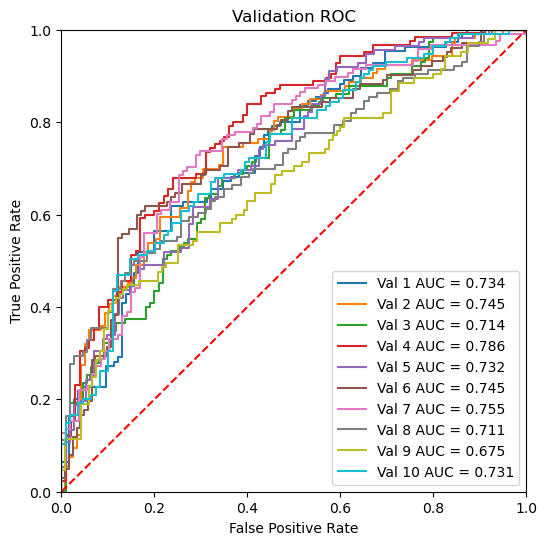

In [257]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('LSTM_WE_val.png')

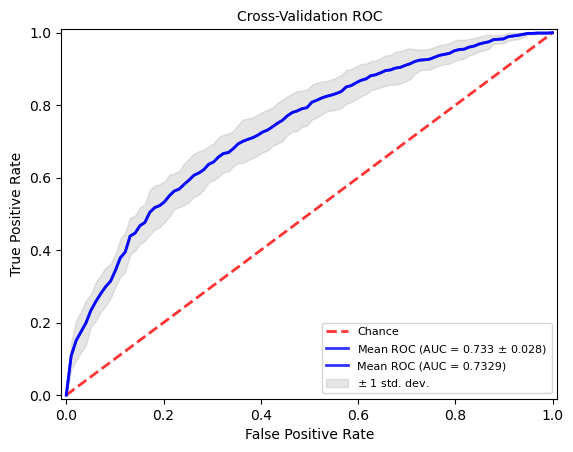

In [258]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('LSTM_WE_val_mean.png')
plt.show()

In [259]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [260]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)
my_calculate_metrics_list_val

[{'SN': 0.7,
  'SP': 0.5826086956521739,
  'ACC': 0.64,
  'MCC': 0.28429929116429703,
  'Recall': 0.7,
  'Precision': 0.616,
  'F1-score': 0.6553191489361702,
  'Cutoff': 0.5},
 {'SN': 0.7641509433962265,
  'SP': 0.5677966101694916,
  'ACC': 0.6607142857142857,
  'MCC': 0.3368856632926854,
  'Recall': 0.7641509433962265,
  'Precision': 0.6136363636363636,
  'F1-score': 0.680672268907563,
  'Cutoff': 0.5},
 {'SN': 0.6608695652173913,
  'SP': 0.6545454545454545,
  'ACC': 0.6577777777777778,
  'MCC': 0.3153651635988163,
  'Recall': 0.6608695652173913,
  'Precision': 0.6666666666666666,
  'F1-score': 0.6637554585152838,
  'Cutoff': 0.5},
 {'SN': 0.616,
  'SP': 0.79,
  'ACC': 0.6933333333333334,
  'MCC': 0.40687981161807746,
  'Recall': 0.616,
  'Precision': 0.7857142857142857,
  'F1-score': 0.6905829596412556,
  'Cutoff': 0.5},
 {'SN': 0.75,
  'SP': 0.5663716814159292,
  'ACC': 0.6577777777777778,
  'MCC': 0.3217555905519542,
  'Recall': 0.75,
  'Precision': 0.631578947368421,
  'F1-score'

In [261]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.700000,0.582609,0.640000,0.284299,0.700000,0.616000,0.655319,0.5
1,0.764151,0.567797,0.660714,0.336886,0.764151,0.613636,0.680672,0.5
2,0.660870,0.654545,0.657778,0.315365,0.660870,0.666667,0.663755,0.5
3,0.616000,0.790000,0.693333,0.406880,0.616000,0.785714,0.690583,0.5
4,0.750000,0.566372,0.657778,0.321756,0.750000,0.631579,0.685714,0.5
5,0.803922,0.528455,0.653333,0.341279,0.803922,0.585714,0.677686,0.5
6,0.652542,0.747664,0.697778,0.400873,0.652542,0.740385,0.693694,0.5
7,0.698276,0.541284,0.622222,0.242749,0.698276,0.618321,0.655870,0.5
8,0.600000,0.608333,0.604444,0.207921,0.600000,0.572727,0.586047,0.5
9,0.626087,0.706422,0.665179,0.333241,0.626087,0.692308,0.657534,0.5


In [262]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.700000,0.582609,0.640000,0.284299,0.700000,0.616000,0.655319,0.5
1,0.764151,0.567797,0.660714,0.336886,0.764151,0.613636,0.680672,0.5
2,0.660870,0.654545,0.657778,0.315365,0.660870,0.666667,0.663755,0.5
3,0.616000,0.790000,0.693333,0.406880,0.616000,0.785714,0.690583,0.5
4,0.750000,0.566372,0.657778,0.321756,0.750000,0.631579,0.685714,0.5
5,0.803922,0.528455,0.653333,0.341279,0.803922,0.585714,0.677686,0.5
6,0.652542,0.747664,0.697778,0.400873,0.652542,0.740385,0.693694,0.5
7,0.698276,0.541284,0.622222,0.242749,0.698276,0.618321,0.655870,0.5
8,0.600000,0.608333,0.604444,0.207921,0.600000,0.572727,0.586047,0.5
9,0.626087,0.706422,0.665179,0.333241,0.626087,0.692308,0.657534,0.5


In [263]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\result\LSTM_WE_performance_val.csv',encoding='utf-8')

In [264]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [265]:
roc_auc_list_indep

[0.7575733418367347,
 0.7772640306122449,
 0.7269610969387755,
 0.7488839285714285,
 0.7659438775510203,
 0.7411511479591836,
 0.7594866071428572,
 0.7396364795918366,
 0.7693718112244898,
 0.7050382653061225]

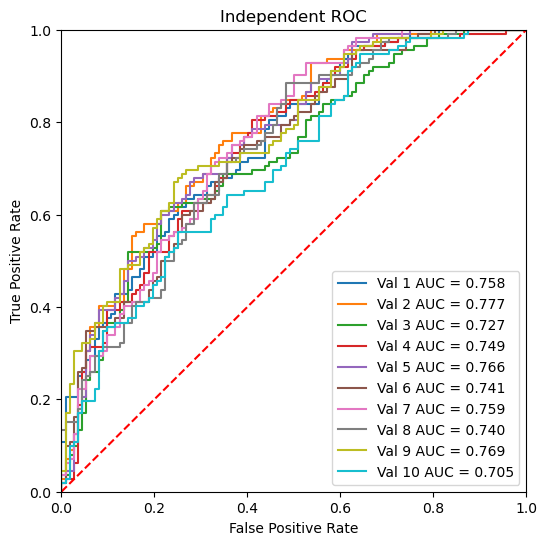

In [266]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('LSTM_WE_indep.png')
plt.show()

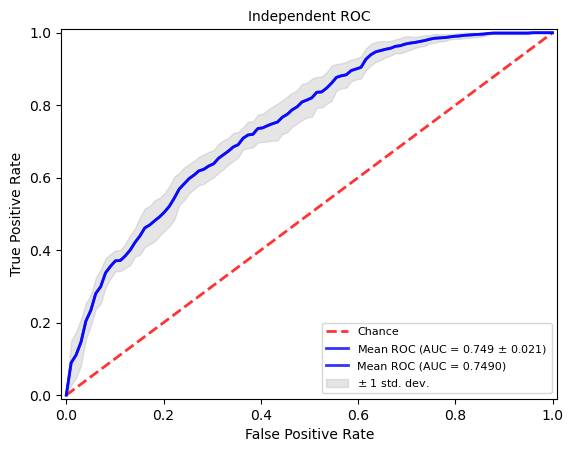

In [267]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('LSTM_WE_indep_mean.png')
plt.show()

In [268]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [269]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)
my_calculate_metrics_list_indep

[{'SN': 0.7232142857142857,
  'SP': 0.5982142857142857,
  'ACC': 0.6607142857142857,
  'MCC': 0.32396954829362334,
  'Recall': 0.7232142857142857,
  'Precision': 0.6428571428571429,
  'F1-score': 0.680672268907563,
  'Cutoff': 0.5},
 {'SN': 0.7857142857142857,
  'SP': 0.5714285714285714,
  'ACC': 0.6785714285714286,
  'MCC': 0.36563621206356534,
  'Recall': 0.7857142857142857,
  'Precision': 0.6470588235294118,
  'F1-score': 0.7096774193548387,
  'Cutoff': 0.5},
 {'SN': 0.6875,
  'SP': 0.5982142857142857,
  'ACC': 0.6428571428571429,
  'MCC': 0.2868599887857916,
  'Recall': 0.6875,
  'Precision': 0.6311475409836066,
  'F1-score': 0.6581196581196581,
  'Cutoff': 0.5},
 {'SN': 0.625,
  'SP': 0.7142857142857143,
  'ACC': 0.6696428571428571,
  'MCC': 0.34064623668312755,
  'Recall': 0.625,
  'Precision': 0.6862745098039216,
  'F1-score': 0.6542056074766355,
  'Cutoff': 0.5},
 {'SN': 0.7946428571428571,
  'SP': 0.5625,
  'ACC': 0.6785714285714286,
  'MCC': 0.3671734096770158,
  'Recall': 0.

In [270]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.723214,0.598214,0.660714,0.323970,0.723214,0.642857,0.680672,0.5
1,0.785714,0.571429,0.678571,0.365636,0.785714,0.647059,0.709677,0.5
2,0.687500,0.598214,0.642857,0.286860,0.687500,0.631148,0.658120,0.5
3,0.625000,0.714286,0.669643,0.340646,0.625000,0.686275,0.654206,0.5
4,0.794643,0.562500,0.678571,0.367173,0.794643,0.644928,0.712000,0.5
5,0.794643,0.517857,0.656250,0.325205,0.794643,0.622378,0.698039,0.5
6,0.571429,0.741071,0.656250,0.317096,0.571429,0.688172,0.624390,0.5
7,0.741071,0.598214,0.669643,0.342802,0.741071,0.648438,0.691667,0.5
8,0.714286,0.633929,0.674107,0.349344,0.714286,0.661157,0.686695,0.5
9,0.616071,0.651786,0.633929,0.268028,0.616071,0.638889,0.627273,0.5


In [271]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.723214,0.598214,0.660714,0.323970,0.723214,0.642857,0.680672,0.5
1,0.785714,0.571429,0.678571,0.365636,0.785714,0.647059,0.709677,0.5
2,0.687500,0.598214,0.642857,0.286860,0.687500,0.631148,0.658120,0.5
3,0.625000,0.714286,0.669643,0.340646,0.625000,0.686275,0.654206,0.5
4,0.794643,0.562500,0.678571,0.367173,0.794643,0.644928,0.712000,0.5
5,0.794643,0.517857,0.656250,0.325205,0.794643,0.622378,0.698039,0.5
6,0.571429,0.741071,0.656250,0.317096,0.571429,0.688172,0.624390,0.5
7,0.741071,0.598214,0.669643,0.342802,0.741071,0.648438,0.691667,0.5
8,0.714286,0.633929,0.674107,0.349344,0.714286,0.661157,0.686695,0.5
9,0.616071,0.651786,0.633929,0.268028,0.616071,0.638889,0.627273,0.5


In [272]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\LSTM_WE\result\LSTM_WE_performance_indep.csv',encoding='utf-8')

In [273]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

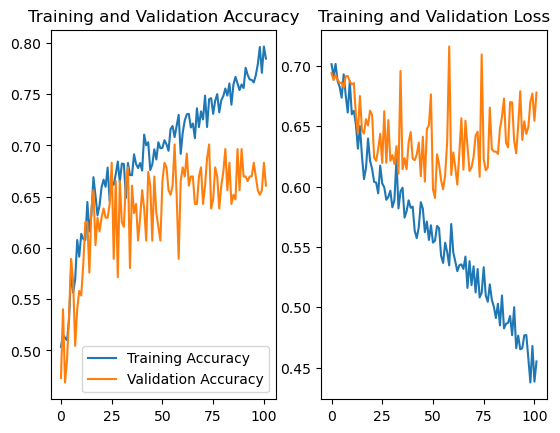

In [274]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()